# Linear and logistic regression modeling, a case study with the NHANES data

This notebook introduces two statistical modeling techniques: linear
regression and logistic regression.  The focus here will be on fitting
these two types of models to data, using Python statistical modeling
libraries in the Jupyter notebook environment.  As with several previous
case studies in this course, here we will be analyzing the
[NHANES](https://www.cdc.gov/nchs/nhanes/index.htm) data, allowing us
to illustrate the use of these two regression methods for addressing
meaningful questions with actual data.

Note that the NHANES data were collected as a designed survey, and in
general should be analyzed as such.  This means that survey design
information such as weights, strata, and clusters should be accounted
for in any analysis using NHANES.  But to introduce how linear and
logistic regression are used with independent data samples, or with convenience
samples, we will not incorporate the survey structure of the NHANES sample
into the analyses conducted here.

As with our previous work, we will be using the
[Pandas](http://pandas.pydata.org) library for data management, the
[Numpy](http://www.numpy.org) library for numerical calculations, and
the [Statsmodels](http://www.statsmodels.org) library for statistical
modeling.

We begin by importing the libraries that we will be using.

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import numpy as np

Next we will load the data.  The NHANES study encompasses multiple
waves of data collection.  Here we will only use the
2015-2016 data.  As with most data sets, there are some missing values
in the NHANES files.  While many of the methods demonstrated below would handle
missing values automatically (at least in a crude way), here we drop
up-front all rows with missing values in any of the key variables that
we will use in this notebook.

In [42]:
# Read the 2015-2016 wave of NHANES data
da = pd.read_csv("nhanes_2015_2016.csv")

# Drop unused columns, and drop rows with any missing values.
vars = ["BPXSY1", "RIDAGEYR", "RIAGENDR", "RIDRETH1", "DMDEDUC2", "BMXBMI", "SMQ020"]
da = da[vars].dropna()

In [43]:
da.head()

,BPXSY1,RIDAGEYR,RIAGENDR,RIDRETH1,DMDEDUC2,BMXBMI,SMQ020
0,128.0,62,1,3,5.0,27.8,1
1,146.0,53,1,3,3.0,30.8,1
2,138.0,78,1,3,3.0,28.8,1
3,132.0,56,2,3,5.0,42.4,2
4,100.0,42,2,4,4.0,20.3,2


## Linear regression

We will focus initially on regression models in which systolic [blood
pressure](https://en.wikipedia.org/wiki/Blood_pressure) (SBP)
is the outcome (dependent) variable.  That is, we will
predict SBP from other variables.  SBP is an important indicator of
cardiovascular health.  It tends to increase with age, is greater for
overweight people (i.e. people with greater body mass index or BMI),
and also differs among demographic groups, for example among gender
and ethnic groups.

Since SBP is a quantitative variable, we will model it using linear
regression.  Linear regression is the most widely-utilized form of
statistical regression.  While linear regression is commonly used with
quantitative outcome variables, it is not the only type of regression
model that can be used with quantitative outcomes, nor is it the case
that linear regression can only be used with quantitative outcomes.
However, linear regression is a good default starting point for any
regression analysis using a quantitative outcome variable.

### Interpreting regression parameters in a basic model

We start with a simple linear regression model with only one
covariate, age, predicting SBP.  In the NHANES data, the variable
[BPXSY1](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/BPX_I.htm#BPXSY1)
contains the first recorded measurement of SBP for a subject, and
[RIDAGEYR](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#RIDAGEYR)
is the subject's age in years.  The model that is fit in the next cell
expresses the expected SBP as a linear function of age:

In [44]:
model = sm.OLS.from_formula("BPXSY1 ~ RIDAGEYR", data=da)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 BPXSY1   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     1333.
Date:                Tue, 18 Apr 2023   Prob (F-statistic):          2.09e-259
Time:                        14:50:57   Log-Likelihood:                -21530.
No. Observations:                5102   AIC:                         4.306e+04
Df Residuals:                    5100   BIC:                         4.308e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    102.0935      0.685    149.120      0.000     100.751     103.436
RIDAGEYR       0.4759      0.013     36.504      0.000       0.450       0.501
==============================================================================
Omnibus:                      690.261   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1505.999
Skew:                           0.810   Prob(JB):                         0.00
Kurtosis:                       5.112   Cond. No.                         156.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Much of the output above is not relevant for us, so focus on
the center section of the output where the header begins with
__coef__.  This section contains the estimated
values of the parameters of the regression model, their standard
errors, and other values that are used to quantify the uncertainty
in the regression parameter estimates.  Note that the parameters
of a regression model, which appear in the column labeled
__coef__ in the table above,
may also be referred to as *slopes* or *effects*.

This fitted model implies that when
comparing two people whose ages differ by one year, the older person
will on average have 0.48 units higher SBP than the younger person.
This difference is statistically significant, based on the p-value
shown under the column labeled __`P>|t|`__.  This means that there
is strong evidence that there is a real association between between systolic blood
pressure and age in this population.

SBP is measured in units of *millimeters of mercury*, expressed
*mm/Hg*.  In order to better understand the meaning of the estimated
regression parameter 0.48, we can look at the standard deviation of SBP:

In [45]:
da.BPXSY1.std()

18.486559500781865

The standard deviation of around 18.5 is large compared to the
regression slope of 0.48.  However the regression slope corresponds to
the average change in SBP for a single year of age, and this effect
accumulates with age.  Comparing a 40 year-old person to a 60 year-old
person, there is a 20 year difference in age, which translates into a
`20 * 0.48 = 9.6` unit difference in average SBP between these two
people.  This difference is around half of one standard deviation, and
would generally be considered to be an important and meaningful shift.

### R-squared and correlation

In the case of regression with a
single independent variable, as we have here, there is a very close
correspondence between the regression analysis and a Pearson
correlation analysis, which we have discussed earlier in course 2.
The primary summary statistic for assessing the strength of a
predictive relationship in a regression model is the *R-squared*, which is
shown to be 0.207 in the regression output above.  **This means that 21%
of the variation in SBP is explained by age.**  Note that this value is
exactly the **same as the squared Pearson correlation coefficient**
between SBP and age, as shown below.

In [46]:
cc = da[["BPXSY1", "RIDAGEYR"]].corr()
print(cc.BPXSY1.RIDAGEYR**2)

0.2071545962518702


There is a second way to interpret the R-squared, which makes use
of the *fitted values* of the regression.  The fitted values are
predictions of the blood pressure for each person in the data
set, based on their covariate values.  In this case, the only
covariate is age, so we are predicting each NHANES subject's
blood pressure as a function of their age.  If we calculate
the Pearson correlation coefficient between the fitted values
from the regression, and the actual SBP values, and then square
this correlation coefficient, we see
that we also get the R-squared from the regression:

In [47]:
cc = np.corrcoef(da.BPXSY1, result.fittedvalues)
print(cc[0, 1]**2)

0.20715459625186952


Thus, we see that in a linear model fit with only one covariate,
the regression R-squared is equal to the squared Pearson
correlation between the covariate and the outcome, and is also
equal to the squared Pearson correlation between the fitted
values and the outcome.

### Adding a second variable

Above we considered a simple linear regression analysis with only one
covariate (age) predicting systolic blood pressure (SBP).  The real
power of regression analysis arises when we have more than one
covariate predicting an outcome.  As noted above, SBP is expected to
be related to gender as well as to age, so we next add gender to the
model.  The NHANES variable for gender is named
[RIAGENDR](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#RIAGENDR)

We begin by creating a relabeled version of the gender variable:

In [48]:
# Create a labeled version of the gender variable
da["RIAGENDRx"] = da.RIAGENDR.replace({1: "Male", 2: "Female"})

Now we are ready to fit the linear model:

In [49]:
model = sm.OLS.from_formula("BPXSY1 ~ RIDAGEYR + RIAGENDRx", data=da)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 BPXSY1   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     697.4
Date:                Tue, 18 Apr 2023   Prob (F-statistic):          1.87e-268
Time:                        14:51:00   Log-Likelihood:                -21505.
No. Observations:                5102   AIC:                         4.302e+04
Df Residuals:                    5099   BIC:                         4.304e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           100.6305      0.712    141.257      0.000      99.234     102.027
RIAGENDRx[T.Male]     3.2322      0.459      7.040      0.000       2.332       4.132
RIDAGEYR              0.4739      0.013     36.518      0.000       0.448       0.499
==============================================================================
Omnibus:                      706.732   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1582.730
Skew:                           0.818   Prob(JB):                         0.00
Kurtosis:                       5.184   Cond. No.                         168.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The syntax `RIDAGEYR + RIAGENDRx` in the cell above does not mean
that these two variables are literally added together.  Instead,
it means that these variables are both included in the model as
predictors of blood pressure (`BPXSY1`).

The model that was fit above uses both age and gender to explain the
variation in SBP.  It finds that two people with the same gender whose
ages differ by one year tend to have blood pressure values differing
by 0.47 units, which is essentially the same age parameter that we found above in
the model based on age alone.  This model also shows us that comparing
a man and a woman of the same age, the man will on average have 3.23 units
greater SBP.

It is very important to emphasize that the age coefficient of 0.47 is
only meaningful when comparing two people of the same gender, and the
gender coefficient of 3.23 is only meaningful when comparing two
people of the same age.
Moreover, these effects are additive, meaning that if we compare, say, a 50 year
old man to a 40 year old woman, the man's blood pressure will on
average be around 3.23 + 10*0.47 = 7.93 units higher, with the first
term in this sum being attributable to gender, and the second term
being attributable to age.

We noted above that the regression coefficient for age did not change
by much when we added gender to the model.  It is important to note
however that in general, the estimated coefficient of a variable in a
regression model will change when other variables are added or
removed.  The only circumstance in which a regresion parameters is unchanged
when other variables are added or removed from the model is when those
variables are uncorrelated with the variables that remain in the model.

Below we confirm that gender and age are nearly uncorrelated in this
data set (the correlation of around -0.02 is negligible).  Thus, it is
expected that when we add gender to the model, the age coefficient
is unaffected.

In [50]:
# We need to use the original, numerical version of the gender
# variable to calculate the correlation coefficient.
da[["RIDAGEYR", "RIAGENDR"]].corr()

,RIDAGEYR,RIAGENDR
RIDAGEYR,1.000000,-0.021398
RIAGENDR,-0.021398,1.000000


Observe that in the regression output shown above, an R-squared value of 0.215 is
listed.  Earlier we saw that for a model with only one covariate,
the R-squared from the regression could be defined in two different
ways, either as the squared correlation coefficient between the covariate and the outcome,
or as the squared correlation coefficient between the fitted values and the outcome.
When more than one covariate is in the model, only the second of these
two definitions continues to hold:

In [51]:
cc = np.corrcoef(da.BPXSY1, result.fittedvalues)
print(cc[0, 1]**2)

0.2147858108624381


### Categorical variables and reference levels

In the model fit above, gender is a categorical variable, and only a
coefficient for males is included in the regression output (i.e. there
is no coefficient for females in the tables above).  Whenever a categorical variable is
used as a covariate in a regression model, one level of the variable
is omitted and is automatically given a coefficient of zero.  This
level is called the *reference level* of the covariate.  Here, the
female level of the gender variable is the reference level.  This does
not mean that being a woman has no impact on blood pressure.  It
simply means that we have written the model so that female blood
pressure is the default, and the coefficient for males (3.23) shifts
the blood pressure by that amount for males only.

We could alternatively have set 'male' to be the reference level, in
which case males would be the default, and the female coefficient
would have been around -3.23 (meaning that female blood pressure is
3.23 units lower than the male blood pressure).

When using a categorical variable as a predictor in a regression
model, it is recoded into "dummy variables" (also known as "indicator
variables").  A dummy variable for a single level, say `a`, of a
variable `x`, is a variable that is equal to `1` when `x=a` and is
equal to `0` when `x` is not equal to `a`.  These dummy variables are
all included in the regression model, to represent the variable that they
are derived from.

Statsmodels, like most software, will automatically recode a
categorical variable into dummy variables, and will select a reference
level (it is possible to override this choice, but we do not cover that
here).  When interpreting the regression output, the level that is
omitted should be seen as having a coefficient of 0, with a standard
error of 0.  It is important to note that the selection of a reference
level is arbitrary and does not imply an assumption or constraint
about the model, or about the population that it is intended to capture.

### A model with three variables

Next we add a third variable, body mass index (BMI), to the model predicting SBP.
[BMI](https://en.wikipedia.org/wiki/Body_mass_index) is a measure that is used
to assess if a person has healthy weight given their height.
[BMXBMI](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/BMX_I.htm#BMXBMI)
is the NHANES variable containing the BMI value for each subject.

In [52]:
model = sm.OLS.from_formula("BPXSY1 ~ RIDAGEYR + BMXBMI + RIAGENDRx", data=da)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 BPXSY1   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     502.0
Date:                Tue, 18 Apr 2023   Prob (F-statistic):          8.54e-286
Time:                        14:51:05   Log-Likelihood:                -21461.
No. Observations:                5102   AIC:                         4.293e+04
Df Residuals:                    5098   BIC:                         4.296e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            91.5840      1.198     76.456      0.000      89.236      93.932
RIAGENDRx[T.Male]     3.5783      0.457      7.833      0.000       2.683       4.474
RIDAGEYR              0.4709      0.013     36.582      0.000       0.446       0.496
BMXBMI                0.3060      0.033      9.351      0.000       0.242       0.370
==============================================================================
Omnibus:                      752.325   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1776.087
Skew:                           0.847   Prob(JB):                         0.00
Kurtosis:                       5.343   Cond. No.                         316.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Not surprisingly, BMI is positively associated with SBP.  Given two
subjects with the same gender and age, and whose BMI differs by 1
unit, the person with greater BMI will have, on average, 0.31 units
greater systolic blood pressure (SBP).  Also note that after adding
BMI to the model, the coefficient for gender became somewhat greater.
This is due to the fact that the three covariates in the model, age,
gender, and BMI, are mutually correlated, as shown next:

In [53]:
da[["RIDAGEYR", "RIAGENDR", "BMXBMI"]].corr()

,RIDAGEYR,RIAGENDR,BMXBMI
RIDAGEYR,1.000000,-0.021398,0.023089
RIAGENDR,-0.021398,1.000000,0.080463
BMXBMI,0.023089,0.080463,1.000000


Although the correlations among these three variables are not strong,
they are sufficient to induce fairly substantial differences in the
regression coefficients (e.g. the gender coefficient changes from 3.23
to 3.58).  In this example, the gender effect becomes larger after we
control for BMI - we can take this to mean that BMI was masking part
of the association between gender and blood pressure.  In other settings, including
additional covariates can reduce the association between a covariate
and an outcome.

### Visualization of the fitted models

In this section we demonstrate some graphing techniques that can be
used to gain a better understanding of a regression model that has
been fit to data.

We start with plots that allow us to visualize the fitted regression
function, that is, the mean systolic blood pressure expressed as a
function of the covariates.  These plots help to show the estimated
role of one variable when the other variables are held fixed.  We will
also plot 95% *simultaneous confidence bands* around these fitted
lines.  Although the estimated mean curve is never exact based on a
finite sample of data, we can be 95% confident that the true mean
curve falls somewhere within the shaded regions of the plots below.

This type of plot requires us to fix the values of all variables
other than the independent variable (SBP here), and one independent
variable that we call the *focus variable* (which is age here).
Below we fix the gender as "female" and the BMI as 25.  Thus,
the graphs below show the relationship between expected SBP
and age for women with BMI equal to 25.

/Users/ivy/opt/miniconda3/envs/ml_mac/lib/python3.8/site-packages/statsmodels/sandbox/predict_functional.py:191: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  fexog.loc[:, ky] = values[ky]


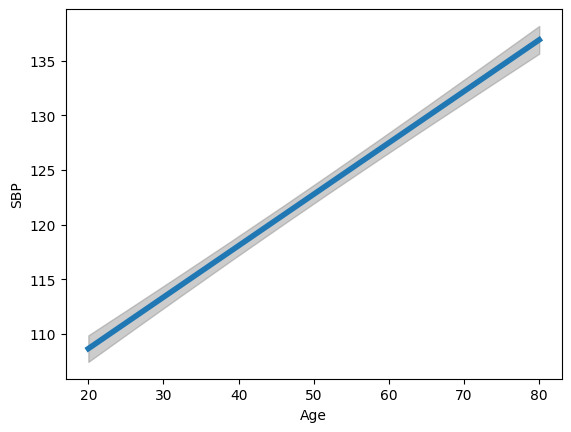

In [60]:
from statsmodels.sandbox.predict_functional import predict_functional

# Fix certain variables at reference values.  Not all of these
# variables are used here, but we provide them with a value anyway
# to prevent a warning message from appearing.
values = {"RIAGENDRx": "Female", "RIAGENDR": 1, "BMXBMI": 25,
          "DMDEDUC2": 1, "RIDRETH1": 1, "SMQ020": 1}

# The returned values are the predicted values (pr), the confidence bands (cb),
# and the function values (fv).
pr, cb, fv = predict_functional(result, "RIDAGEYR",
                values=values, ci_method="simultaneous")

ax = sns.lineplot(x=fv, y=pr, lw=4)
ax.fill_between(fv, cb[:, 0], cb[:, 1], color='grey', alpha=0.4)
ax.set_xlabel("Age")
_ = ax.set_ylabel("SBP")

The analogous plot for BMI is shown next.  Here we fix the
gender as "female" and the age at 50, so we are looking
at the relationship between expected SBP and age for women
of age 50.

/Users/ivy/opt/miniconda3/envs/ml_mac/lib/python3.8/site-packages/statsmodels/sandbox/predict_functional.py:191: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  fexog.loc[:, ky] = values[ky]


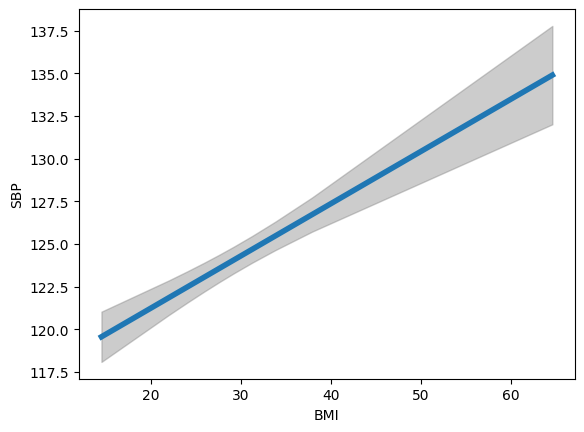

In [61]:
del values["BMXBMI"] # Delete this as it is now the focus variable
values["RIDAGEYR"] = 50
pr, cb, fv = predict_functional(result, "BMXBMI",
                values=values, ci_method="simultaneous")

ax = sns.lineplot(x=fv, y=pr, lw=4)
ax.fill_between(fv, cb[:, 0], cb[:, 1], color='grey', alpha=0.4)
ax.set_xlabel("BMI")
_ = ax.set_ylabel("SBP")

The error band for BMI is notably wider than the error band for age,
indicating that there is less certainty about the relationship between
BMI and SBP compared to the relationship between age and SBP.

The discussion so far has primarily focused on the mean structure of
the population, that is, the model for the average SBP of a person
with a given age, gender, and BMI.  A regression model can also be
used to assess the *variance structure* of the population, that is,
how much and in what manner the observations deviate from their mean.
We will focus on informal, graphical methods for assessing this.

To begin with, we plot the residuals against the fitted values.
Recall that the fitted values are the estimated means for each
observation, and the residuals are the difference between an
observation and its fitted mean.  For example, the model may estimate
that a 50 year old female will have on average an SBP of 125.  But a
specific 50 year old female may have a blood pressure of 110 or 150,
for example.  The fitted values for both of these women are 125, and
their residuals are -15, and 25, respectively.

The simplest variance pattern that we can see in a linear regression
occurs when the points are scattered around the mean, with the same
degree of scatter throughout the range of the covariates.  When there
are multiple covariates, it is hard to assess whether the variance is
uniform throughout this range, but we can easily check for a
"mean/variance relationship", in which there is a systematic relationship
between the variance and the mean, i.e. the variance either increases
or decreases systematically with the mean.  The plot of residuals on fitted values is
used to assess whether such a mean/variance relationship is present.

Below we show the plot of residuals on fitted values for the NHANES
data.  It appears that we have a modestly increasing mean/variance
relationship.  That is, the scatter around the mean blood pressure is
greater when the mean blood pressure itself is greater.

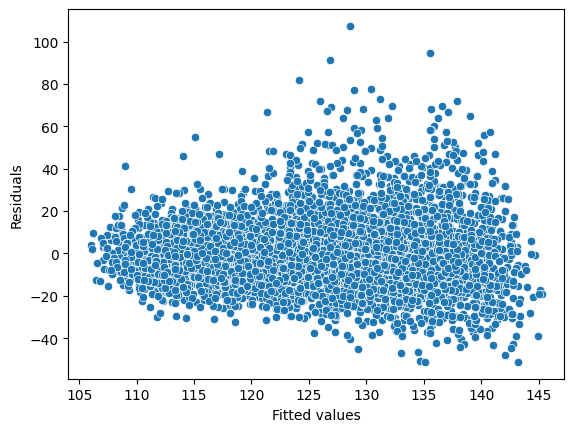

In [63]:
pp = sns.scatterplot(x=result.fittedvalues, y=result.resid)
pp.set_xlabel("Fitted values")
_ = pp.set_ylabel("Residuals")

A "component plus residual plot" or "partial residual plot" is
intended to show how the data would look if all but one covariate
could be fixed at reference values.  By controlling the values of
these covariates, all remaining variation is due either to the "focus
variable" (the one variable that is left unfixed, and is plotted on
the horizontal axis), or to sources of variation that are unexplained
by any of the covariates.

For example, the partial residual plot below shows how age (horizontal
axis) and SBP (vertical axis) would be related if gender and BMI were
fixed.  Note that the origin of the vertical axis in these plots is
not meaningful (we are not implying that anyone's blood pressure would
be negative), but the differences along the vertical axis are
meaningful.  This plot implies that when BMI and gender are held
fixed, the average blood pressures of an 80 and 18 year old differ by
around 30 mm/Hg.  This plot also shows, as discussed above,
that the deviations from the
mean are somewhat smaller at the low end of the range compared to the
high end of the range.  We also see that at the high end of the range, the
deviations from the mean are somewhat right-skewed, with
exceptionally high SBP values being more common than exceptionally low SBP values.

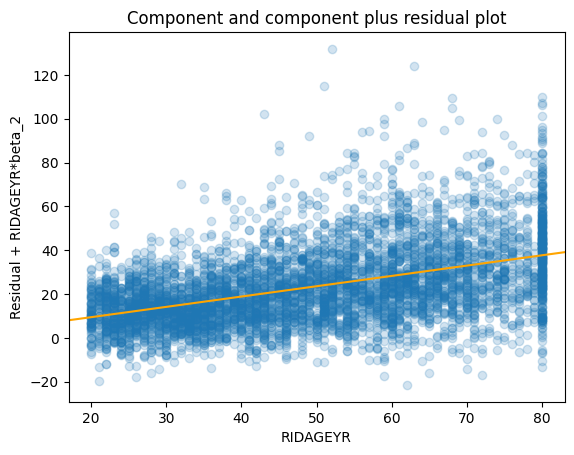

In [64]:
# This is not part of the main Statsmodels API, so needs to be imported separately
from statsmodels.graphics.regressionplots import plot_ccpr

ax = plt.axes()
plot_ccpr(result, "RIDAGEYR", ax)
ax.lines[0].set_alpha(0.2) # Reduce overplotting with transparency
_ = ax.lines[1].set_color('orange')

Next we have a partial residual plot that shows how BMI (horizontal
axis) and SBP (vertical axis) would be related if gender and age were
fixed.  Compared to the plot above, we see here that age is more
uniformly distributed than BMI.  Also, it appears that there is more
scatter in the partial residuals for BMI compared to what we saw above
for age. Thus there seems to be less information about SBP in BMI,
although a trend certainly exists.

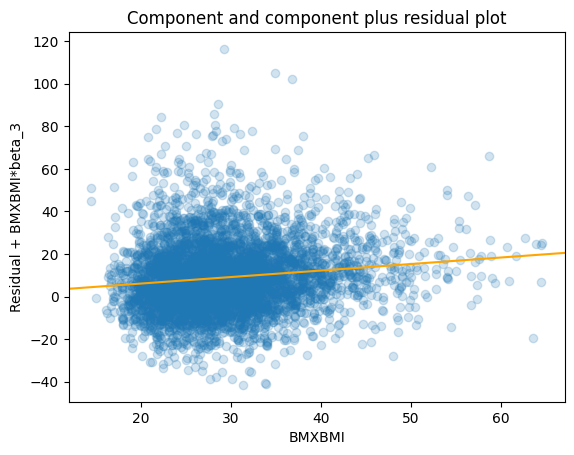

In [65]:
ax = plt.axes()
plot_ccpr(result, "BMXBMI", ax)
ax.lines[0].set_alpha(0.2)
ax.lines[1].set_color("orange")

Another important plot used for understanding a regression model is an "added variable plot".  This is a plot
that may reveal nonlinearity in the relationship between one covariate and the outcome.  Below, we create
an added variable plot for age as a predictor of SBP.  Note that the two variables being plotted (age and blood pressure) have been centered.  The scale of the variables is unchanged, but the origin has been translated to zero.  The red line is an estimte of the relationship between age and blood pressure.  Unlike the relationship in the model, it is not forced to be linear, and there is in fact a hint that the shape is slightly flatter for the first 15 years or so of age.  This would imply that blood pressure increases slightly more slowly for people in theie 20s and early 30s, then begins increasing faster after that point.

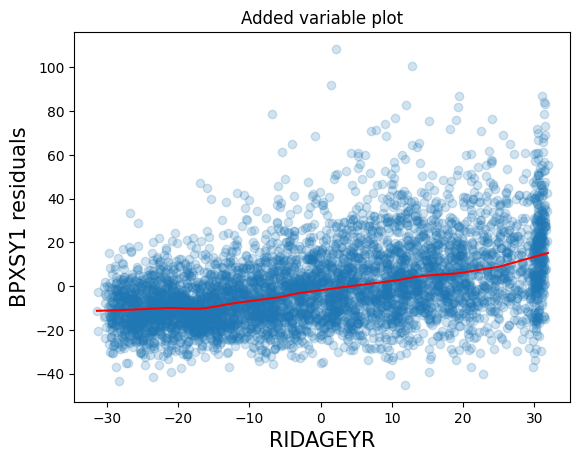

In [66]:
# This is not part of the main Statsmodels API, so needs to be imported separately
from statsmodels.graphics.regressionplots import add_lowess

# This is an equivalent way to fit a linear regression model, it needs to be
# done this way to be able to make the added variable plot
model = sm.GLM.from_formula("BPXSY1 ~ RIDAGEYR + BMXBMI + RIAGENDRx", data=da)
result = model.fit()
result.summary()

fig = result.plot_added_variable("RIDAGEYR")
ax = fig.get_axes()[0]
ax.lines[0].set_alpha(0.2)
_ = add_lowess(ax)

## Logistic regression

We now turn to regression models for *binary* outcome variables,
meaning an outcome that can take on only two distinct values.  For
illustration, we will work with the NHANES variable
[SMQ020](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/SMQ_I.htm#SMQ020),
which asks whether a person has smoked at least 100 cigarettes in
their lifetime (if this is the case, we say that the person has a
"smoking history").  Below we create a version of this variable in
which smoking and non-smoking are coded as 1 and 0, respectively, and
rare responses like *don't know* and *refused to answer* are coded as
missing values.

In [67]:
da["smq"] = da.SMQ020.replace({2: 0, 7: np.nan, 9: np.nan})

### Odds and log odds

Logistic regression provides a model for the *odds* of an event
happening.  Recall that if an event has probability `p`, then the odds
for this event is `p/(1-p)`.  The odds is a mathematical
transformation of the probability onto a different scale.  For
example, if the probability is 1/2, then the odds is 1.

To begin, we look at the odds of alcohol use for women and men separately.

In [68]:
c = pd.crosstab(da.RIAGENDRx, da.smq).apply(lambda x: x/x.sum(), axis=1)
c["odds"] = c.loc[:, 1] / c.loc[:, 0]
c

smq,0.0,1.0,odds
RIAGENDRx,,,
Female,0.680197,0.319803,0.470162
Male,0.467453,0.532547,1.139252


We see that the probability that a woman has ever smoked is
substantially lower than the probability that a man has ever smoked
(30% versus 51%).  This is reflected in the odds for a woman smoking
being much less than 1 (around 0.47), while the odds for a man smoking
is around 1.14.

It is common to work with *odds ratios* when comparing two groups.
This is simply the odds for one group divided by the odds for the
other group.  The odds ratio for smoking, comparing males to females,
is around 2.4.  In other words, a man has around 2.4 times greater
odds of smoking than a woman (in the population represented by these
data).

In [69]:
c.odds.Male / c.odds.Female

2.423105552613186

It is conventional to work with odds on the logarithmic scale.  To
understand the motivation for doing this, first note that the neutral
point for a probability is 0.5, which is equivalent to an odds of 1
and a log odds of 0.  Populations where men smoke more than women will
have odds between 1 and infinity, with the exact value depending on
the magnitude of the relationship between the male and female smoking
rates.  Populations where women smoke more than men would have odds
falling between 0 and 1.

We see that the scale of the odds statistic is not symmetric.  It is
usually arbitrary in which order we compare two groups -- we could
compare men to women, or compare women to men.  An odds of 2 (men have
twice the odds of smoking as women) is equivalent in strength to an
odds of 1/2 (women have twice the odds of smoking as men).  Taking the
log of the odds centers the scale at zero, and symmetrizes the
interpretation of the scale.

To interpret the log odds when comparing two groups,
it is important to remember the following facts:

* A probability of 1/2, an odds of 1, and a log odds
of 0 are all equivalent.

* A positive log odds indicates that the first
group being compared has greater odds (and greater probability) than
the second group.

* A negative log odds indicates that the second
group being compared has greater odds (and greater probability) than
the first group.

* The scale of the log odds statistic is symmetric in
the sense that a log odds of, say, 2, is equivalent in strength to a
log odds of -2 (but with the groups swapped in terms of which has the
greater probability).

If you know that the log odds when comparing two groups is a given
value, say 2, and you want to report the odds, you simply exponentiate
the log odds to get the odds, e.g. `exp(2)` is around 7.4. Note
however that you cannot recover the individual probabilities (or their
ratio) from an odds ratio.`

Below we show the log odds for smoking history status of females and
males in the NHANES data.  The fact that the log odds for females is
negative reflects that fact that substantially less than 50% of
females have a history of smoking.  The log odds for males is closer to
0, consistent with around half of males having a history of smoking.

In [70]:
c["logodds"] = np.log(c.odds)
c

smq,0.0,1.0,odds,logodds
RIAGENDRx,,,,
Female,0.680197,0.319803,0.470162,-0.754679
Male,0.467453,0.532547,1.139252,0.130371


### A basic logistic regression model

Now that we have a clear understanding of log odds statistics, we will
fit a logistic regression.  The dependent variable (outcome) of this
initial model is smoking status, and the only covariate is gender.
Thus, we are looking at gender as a predictor of smoking status.  We
fit the model using the `GLM` function, where `GLM` stands for
*Generalized Linear Model*.  Logistic regression is one type of GLM,
a class which also includes many other regression methods such as Poisson
regression that we do not discuss further here.  As with linear
regression, logistic models also include an intercept parameter, but
we are not focusing on that parameter now.

In [71]:
model = sm.GLM.from_formula("smq ~ RIAGENDRx", family=sm.families.Binomial(), data=da)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    smq   No. Observations:                 5094
Model:                            GLM   Df Residuals:                     5092
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3350.6
Date:                Tue, 18 Apr 2023   Deviance:                       6701.2
Time:                        14:56:49   Pearson chi2:                 5.09e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.04557
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.7547      0.042    -18.071      0.000      -0.837      -0.673
RIAGENDRx[T.Male]     0.8851      0.058     15.227      0.000       0.771       0.999
=====================================================================================
"""

To see the connection between logistic regression and the log odds
statistic, note that the logistic regression coefficient for male
gender is exactly equal to the difference between the log odds
statistics for males and females:

In [72]:
c.logodds.Male - c.logodds.Female

0.8850500036644218

This relationship will always hold when conducting a logistic
regression with a single binary covariate.

In general, a logistic regression model will have multiple covariates
that may not be binary, but there is still an important connection
between logistic regression and odds ratios.  In this more general
setting, we will use a more general type of odds ratio, which we will
explore further next.

### Adding additional covariates

As with linear regression, we can include multiple covariates in a
logistic regression.  Below we fit a logistic regression for smoking
status using age (RIDAGEYR) and gender as covariates.

In [73]:
model = sm.GLM.from_formula("smq ~ RIDAGEYR + RIAGENDRx", family=sm.families.Binomial(), data=da)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    smq   No. Observations:                 5094
Model:                            GLM   Df Residuals:                     5091
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3296.6
Date:                Tue, 18 Apr 2023   Deviance:                       6593.2
Time:                        14:57:28   Pearson chi2:                 5.10e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.06558
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.6166      0.095    -16.985      0.000      -1.803      -1.430
RIAGENDRx[T.Male]     0.8920      0.059     15.170      0.000       0.777       1.007
RIDAGEYR              0.0172      0.002     10.289      0.000       0.014       0.021
=====================================================================================
"""

Adding age to the model leads to a very small shift in the gender
parameter (it changed from 0.885 to 0.892).  In general, regression
coefficients can change a lot when adding or removing other variables
from a model.  But in this case the change is quite minimal.  This
fitted model suggests that older people are more likely to have a
history of smoking than younger people.  The log odds for smoking
increases by 0.017 for each year of age.  This effect is additive, so
that comparing two people whose ages differ by 20 years, the log odds
of the older person smoking will be around 0.34 units greater than the
log odds for the younger person smoking, adn the odds for the older
person smoking will be around `exp(0.34) = 1.4` times greater than
the odds for the younger person smoking.

The greater prevalence of smoking history among older people could be
partly due to the definition of smoking status that we are using here -- an older person has
had more time to smoke 99 cigarettes than a younger person.  However
most people who smoke begin when they are young, and the smoking rate
in the US has been slowly declining for several decades.  Thus, it is
likely that the increased smoking levels in older people are driven
primarily by real shifts in behavior.

As with linear regression, the roles of age and gender in the logistic
regression model can be seen as being additive, but here the additivity
is on the scale of log odds, not odds or probabilities.  If we compare
a 30 year old female to a 50 year old male, the log odds for the male
being a smoker are `0.89 + 0.34 = 1.23` units greater than the log odds
for the female being a smoker.  The value of 0.89 in this expression is
the change attributable to gender, and the value of 0.34 is the change
attributable to age.  Again, we can exponentiate to convert these
effects from the log odds scale to the odds scale.  Since
`exp(0.89 + 0.34) = exp(0.89)*exp(0.34) = 2.44*1.41` we can state
that male gender is associated with a 2.44 fold increase in the odds
of smoking, and 20 years of age is associated with a 1.41 fold increase
in the odds for smoking.  These two effects are multiplied when
discussing the odds, so a 50 year old man has `exp(1.23) = 3.42` fold
greater odds of smoking than a 30 year old woman.

In this logistic regression model with two covariates, the
coefficients for age and gender both have interpretations in terms of
*conditional log odds*.  This generalizes the interpretation of a
logistic regression coefficient in terms of marginal log odds that we
discussed above.  When there are two or more covariates in a logistic
regression model, we always need to think in terms of conditional, not
marginal log odds.

Specifically, the coefficient of around 0.89 for male gender impacts the conditional
log odds in the sense that when comparing a male to a female at a
fixed age, the male will have 0.89 units greater log odds for smoking than
the female.  This relationship holds within any age (i.e. it holds
among all people of age 30, and among all people of age 70).  In this
sense, it is a *conditional* coefficient because it is only
interpretable when holding the other variables in the model fixed.
Similarly, the coefficient of around 0.02 for age holds within a
gender.  Comparing two females whose ages differ by one year, the
older female has 0.02 units greater log odds for smoking than the
younger female.  This same contrast holds for males.

### A logistic regression model with three predictors

Next we fit a logistic regression model, again for smoking, including
educational attainment as a predictor.  The educational attainment in
NHANES is called
[DMDEDUC2](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#DMDEDUC2),
and we will recode it so that the meaning of the levels becomes more
clear.  We will call the recoded variable `DMDEDUC2x`.

In [74]:
# Create a labeled version of the educational attainment variable
da["DMDEDUC2x"] = da.DMDEDUC2.replace({1: "lt9", 2: "x9_11", 3: "HS", 4: "SomeCollege",
                                       5: "College", 7: np.nan, 9: np.nan})

model = sm.GLM.from_formula("smq ~ RIDAGEYR + RIAGENDRx + DMDEDUC2x", family=sm.families.Binomial(), data=da)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    smq   No. Observations:                 5093
Model:                            GLM   Df Residuals:                     5086
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3201.2
Date:                Tue, 18 Apr 2023   Deviance:                       6402.4
Time:                        14:57:47   Pearson chi2:                 5.10e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.09976
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -2.3060      0.114    -20.174      0.000      -2.530      -2.082
RIAGENDRx[T.Male]            0.9096      0.060     15.118      0.000       0.792       1.028
DMDEDUC2x[T.HS]              0.9434      0.090     10.521      0.000       0.768       1.119
DMDEDUC2x[T.SomeCollege]     0.8322      0.084      9.865      0.000       0.667       0.998
DMDEDUC2x[T.lt9]             0.2662      0.109      2.438      0.015       0.052       0.480
DMDEDUC2x[T.x9_11]           1.0986      0.107     10.296      0.000       0.889       1.308
RIDAGEYR                     0.0183      0.002     10.582      0.000       0.015       0.022
============================================================================================
"""

We see that the "Female" level of the gender variable, and the
"College" level of the educational attainment variable are the
reference levels, as they are not shown in the output above.  We have
discussed the gender and age variables above, but the educational
attainment variable is new for us.  All non-reference coefficients for
the educational attainment are positive, while the `College`
coefficient, as the reference coefficient, is exactly zero.  Thus, we
see that people with a college degree have the lowest rate of smoking,
followed by people with less than 9 years of schooling, then
(after a large gap) people
with some college, then people with a high school degree (and no
college), and finally (with the greatest rate of smoking), people with
9-11 years of schooling.  The overall story here is that smoking rates
are much lower for people who graduated from college or did not start
high school, presumably for very different reasons.  On the other
hand, people with some high school, people who completed high school,
and people who began but did not complete college have much higher
rates of smoking.  The odds ratio between the former and the latter
group depends on the specific subgroups being compared, but can be
almost `3 = exp(1.09)`.

As noted above when we were discussing linear regression, it is
important to remember that a coefficient in a logistic regression are
"conditional" on the other variables being held fixed.  For example,
the log odds ratio of 1.09 between people with 9-11 years of schooling
and people who completed college applies only when comparing people with
the same age and gender.

### Visualization of the fitted models

Visualization of fitted logistic regression models is more challenging
than visualization of fitted linear models, but is still worth
pursuing.  We can begin by plotting the fitted proportion of the
population that smokes, for various subpopulations defined by the
regression model.  We will focus here on how the smoking rate varies
with age, so we restrict the population to female college graduates.

The following plot shows the fitted log odds (or logit) probability
for the smoking outcome as a function of age.  The grey band is a
simultaneous 95% simultaneous confidence band, as discussed above in
the case of a linear model.

/Users/ivy/opt/miniconda3/envs/ml_mac/lib/python3.8/site-packages/statsmodels/sandbox/predict_functional.py:191: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  fexog.loc[:, ky] = values[ky]


Text(0, 0.5, 'Smoking')

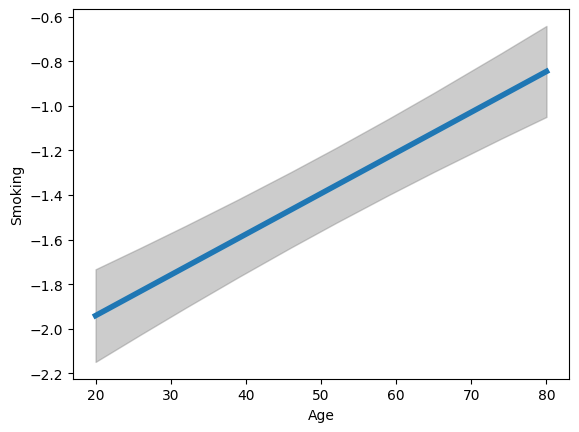

In [76]:
values = {"RIAGENDRx": "Female", "RIAGENDR": 1, "BMXBMI": 25,
          "DMDEDUC2": 1, "RIDRETH1": 1, "SMQ020": 1,
          "DMDEDUC2x": "College", "BPXSY1": 120}

pr, cb, fv = predict_functional(result, "RIDAGEYR",
                values=values, ci_method="simultaneous")

ax = sns.lineplot(x=fv, y=pr, lw=4)
ax.fill_between(fv, cb[:, 0], cb[:, 1], color='grey', alpha=0.4)
ax.set_xlabel("Age")
ax.set_ylabel("Smoking")

We can display the same plot in terms of probabilities instead of in
terms of log odds.  The probability can be obtained from the log odds
using the relationship `p = 1 / (1 + exp(-o))` where `o` is the log
odds.  Note that while the age and log odds are linearly related, age
has a curved relationship with probability.  This is necessary since
probabilities must remain between 0 and 1, a linear relationship would
eventually exit this interval.

Text(0, 0.5, 'Smoking')

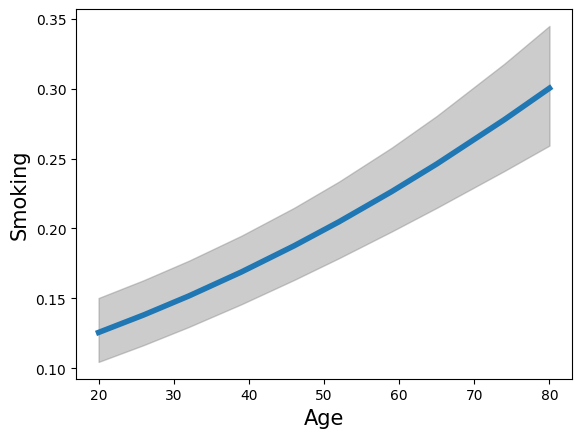

In [78]:
pr1 = 1 / (1 + np.exp(-pr))
cb1 = 1 / (1 + np.exp(-cb))
ax = sns.lineplot(x=fv, y=pr1, lw=4)
ax.fill_between(fv, cb1[:, 0], cb1[:, 1], color='grey', alpha=0.4)
ax.set_xlabel("Age", size=15)
ax.set_ylabel("Smoking", size=15)

Next we turn to diagnostic plots that are intended to reveal certain
aspects of the data that may not be correctly captured by the model.
The three plots below are intended to reveal any curvature in the mean
relationship between the outcome and one of the covariates. We used
the partial regression plotting technique above for this same purpose
when working with linear models.

In the case of logistic regression, the three techniques
demonstrated below can identify
major discrepancies between the fitted model and the population, but
evidence for small discrepancies is not reliable unless the sample
size is very large.  The CERES technique has the strongest theoretical
support.  Taken at face value, the plots below suggest that smoking
rates may rise slightly faster for people between the ages of 20 and 35,
and again for people between the ages of 50 and 60, with a period of minimal
increase between these age intervals.  This would contradict the
perfectly linear model for age (on the log odds scale)
that we have specified in our model.
These plotting techniques can be useful at identifying
possible opportunities for future analysis with additional data, but
do not identify features that can be claimed with high confidence
using the present data.

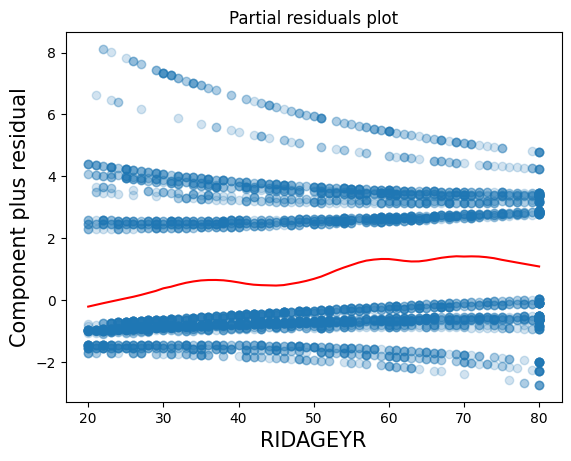

In [79]:
fig = result.plot_partial_residuals("RIDAGEYR")
ax = fig.get_axes()[0]
ax.lines[0].set_alpha(0.2)

_ = add_lowess(ax)

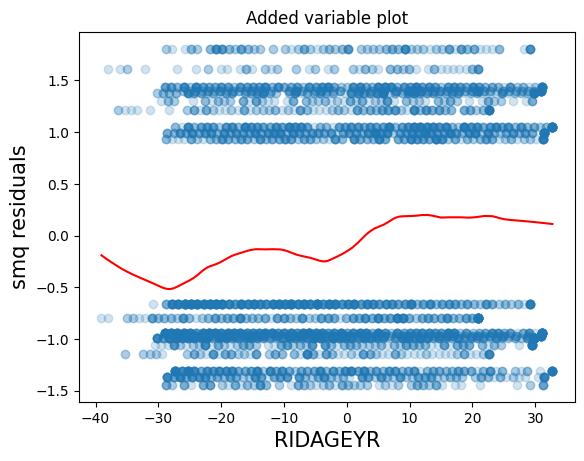

In [80]:
fig = result.plot_added_variable("RIDAGEYR")
ax = fig.get_axes()[0]
ax.lines[0].set_alpha(0.2)
_ = add_lowess(ax)

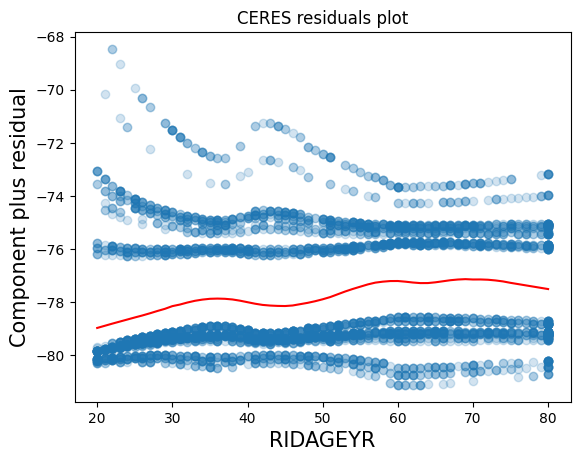

In [81]:
fig = result.plot_ceres_residuals("RIDAGEYR")
ax = fig.get_axes()[0]
ax.lines[0].set_alpha(0.2)
_ = add_lowess(ax)